In [1]:
import numpy as np
import torch
import random
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 设置随机种子
seed = 3407
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 文件列表
file_list = ["Labeled_" + file for file in ["February.csv", "April.csv", "June.csv", "August.csv", "October.csv", "December.csv"]]

# 参数设置
Seq_len = 7*24  # 历史数据长度（15 天）
Pre_len = 24      # 预测长度（24 小时）
features = ['Precipitation','Temperature', 'Wind_speed','Humidity', 'holiday', 'month', 'hour', 'Load']
# features = ['Temperature', 'Humidity', 'holiday', 'month', 'hour', 'Load']

data = pd.read_csv('Labeled_Train Data.csv')
data = data.drop(columns=['DateTime'])
data_np = data.to_numpy().astype(np.float32)

features_indices = [data.columns.get_loc(f) for f in features]

Power_Inputs_list = []
# 处理主数据
for i in range(Seq_len + Pre_len, len(data_np)):
    Power_Input = data_np[i - (Seq_len + Pre_len):i, features_indices]
    Power_Inputs_list.append(Power_Input)

# 转换为 NumPy 数组
# feature维度的最后一个特征是Load
# (num_samples, Seq_len + Pre_len, len(features))
Power_Inputs = np.array(Power_Inputs_list)
print(Power_Inputs.shape)

# 处理其他月份的数据
for file_name in file_list:
    data = pd.read_csv(file_name)
    data = data.drop(columns=['DateTime'])
    data_np = data.to_numpy().astype(np.float32)
    
    for i in range(Seq_len + Pre_len, len(data_np)-24):
        Power_Input = data_np[i - (Seq_len + Pre_len):i, features_indices]
        Power_Inputs_list.append(Power_Input)
Power_Inputs = np.array(Power_Inputs_list)
print(Power_Inputs.shape)




(18096, 192, 8)
(21360, 192, 8)


In [ ]:

# 初始化归一化器
scaler_Load = StandardScaler()
scaler_Feature = StandardScaler()

# 提取负荷特征和其他数值特征的索引
load_index = features.index('Load')
num_feature_indices = [features.index(f) for f in features if f not in ['holiday', 'month', 'hour', 'Load']]

# 归一化非负荷数值特征
Power_Inputs[:, :, num_feature_indices] = scaler_Feature.fit_transform(
    Power_Inputs[:, :, num_feature_indices].reshape(-1,len(num_feature_indices))
).reshape(Power_Inputs[:, :, num_feature_indices].shape)

# 单独归一化负荷特征
Power_Inputs[:, :, load_index] = scaler_Load.fit_transform(
    Power_Inputs[:, :, load_index].reshape(-1, 1)
).reshape(Power_Inputs[:, :, load_index].shape)

print(Power_Inputs.shape)
Augement_feature_indices = [features.index(f) for f in features if f not in ['holiday', 'month', 'hour']]
Augement_shape = Power_Inputs.shape
for _ in range(10):
    mask = np.random.uniform(1.02, 1.05, size=(Augement_shape[0], Augement_shape[1], len(Augement_feature_indices)))
    Temp = Power_Inputs[-Augement_shape[0]:, :, :].copy()
    # print(Augement_shape[0])
    Temp[-Augement_shape[0]:, :, Augement_feature_indices] = Temp[-Augement_shape[0]:, :, Augement_feature_indices] * mask
    print(Temp.shape)
    Power_Inputs = np.concatenate((Temp, Power_Inputs),axis=0)
    print(Power_Inputs.shape)

# 数据集划分
Data_train, Data_Temp = train_test_split(Power_Inputs, test_size=0.4, shuffle=False)
Data_val, Data_test = train_test_split(Data_Temp, test_size=0.5, shuffle=True, random_state=seed)

# 自定义 TimePower Dataset
class TimePowerDataset(Dataset):
    def __init__(self, Data, Seq_len, Pre_len=None):
        self.Data = torch.tensor(Data, dtype=torch.float32)
        self.Seq_len = Seq_len

    def __len__(self):
        return len(self.Data)

    def __getitem__(self, idx):
        En_X = self.Data[idx, :self.Seq_len, -1].unsqueeze(1)
        Ex_X = self.Data[idx, :, :-1]
        En_y = self.Data[idx, self.Seq_len:, -1].unsqueeze(1)
        return En_X, Ex_X, En_y

# 数据加载
batch_size = 10240
train_dataset = TimePowerDataset(Data=Data_train, Seq_len=Seq_len)
val_dataset = TimePowerDataset(Data=Data_val, Seq_len=Seq_len)
test_dataset = TimePowerDataset(Data=Data_test, Seq_len=Seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}, 测试集大小: {len(test_dataset)}")
# 打印数据shape
# for i, (En_X, Ex_X, En_y) in enumerate(train_dataset):
#     print('En_X:',En_X.shape, 'Ex_X:',Ex_X.shape, 'En_y:',En_y.shape)
#     print(scaler_Load.inverse_transform(En_y).shape)
#     break

(21360, 192, 8)
(21360, 192, 8)
(42720, 192, 8)
(21360, 192, 8)
(64080, 192, 8)
(21360, 192, 8)
(85440, 192, 8)
(21360, 192, 8)
(106800, 192, 8)
(21360, 192, 8)
(128160, 192, 8)
(21360, 192, 8)
(149520, 192, 8)
(21360, 192, 8)
(170880, 192, 8)
(21360, 192, 8)
(192240, 192, 8)
(21360, 192, 8)
(213600, 192, 8)
(21360, 192, 8)
(234960, 192, 8)
训练集大小: 140976, 验证集大小: 46992, 测试集大小: 46992


Epoch [1/30], Loss: 0.8697, Train_time Cost: 21.1989
Validation Loss: 4507.8607, Validation MAPE: 9.8461%
Model saved at epoch 1 with MAPE: 9.8461%
Model saved at epoch 1 with MSE: 4507.8607
Epoch [2/30], Loss: 0.2250, Train_time Cost: 21.2751
Validation Loss: 3815.2734, Validation MAPE: 9.0465%
Model saved at epoch 2 with MAPE: 9.0465%
Model saved at epoch 2 with MSE: 3815.2734
Epoch [3/30], Loss: 0.1958, Train_time Cost: 21.2926
Validation Loss: 3162.7461, Validation MAPE: 8.2152%
Model saved at epoch 3 with MAPE: 8.2152%
Model saved at epoch 3 with MSE: 3162.7461
Epoch [4/30], Loss: 0.1769, Train_time Cost: 21.2711
Validation Loss: 2903.3800, Validation MAPE: 7.7962%
Model saved at epoch 4 with MAPE: 7.7962%
Model saved at epoch 4 with MSE: 2903.3800
Epoch [5/30], Loss: 0.1658, Train_time Cost: 21.3075
Validation Loss: 2776.2695, Validation MAPE: 7.6011%
Model saved at epoch 5 with MAPE: 7.6011%
Model saved at epoch 5 with MSE: 2776.2695
Epoch [6/30], Loss: 0.1574, Train_time Cost: 

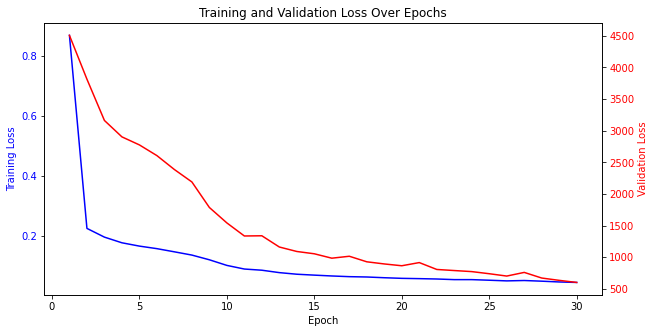

Final model saved.


In [3]:
from math import sqrt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from TimePower import TimePower

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len=24* 7        # Endogenous变量长度
pre_len=24          # 待预测时段长度
d_model=512         # Patch of Endogenous Variables和 Exogenous Variables嵌入长度
patch_len=24        # 单个Patch长度
n_heads=8           # Num of Multihead
d_ff=2048           # FFN中间层维度，一般是4*d_model
e_layers=10          # 编码器层数

# TimePower模型的初始化
model = TimePower(seq_len=seq_len,pre_len=pre_len,d_model=d_model,patch_len=patch_len,n_heads=n_heads,d_ff=d_ff,e_layers=e_layers,use_norm=True,time_embed=5)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# 初始化用于可视化损失的列表
train_losses = []
val_losses = []

best_mape = float("inf")
best_mse = float("inf")
num_epochs = 30        # 总训练轮数
# warmup_epochs = 10        # 预热轮数
# eta_min = 1e-5            # 最小学习率
# eta_max = 1e-4            # 最大学习率

# # 定义调度函数
# def lr_lambda(current_epoch):
#     if current_epoch < warmup_epochs:
#         # Warm-up阶段：线性增长
#         return current_epoch / warmup_epochs
#     else:
#         # 余弦退火阶段
#         return 0.5 * (1 + math.cos(math.pi * (current_epoch - warmup_epochs) / (num_epochs - warmup_epochs)))

# # 创建学习率调度器
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# 模型加载到设备
model.to(device)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    # 训练阶段
    for i, (En_X, Ex_X, En_y) in enumerate(train_loader):
        
        En_X = En_X.to(device)
        Ex_X = Ex_X.to(device)
        En_y = En_y.to(device)
        
        # 前向传播
        outputs = model(En_X, Ex_X)
        
        # 计算损失
        loss = criterion(outputs, En_y)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()

        # 梯度裁剪
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        # 更新学习率
        # scheduler.step()

        running_loss += loss.item()

    # 打印训练损失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train_time Cost: {(time.time() - start_time):.4f}"
    )

    # 验证阶段
    model.eval()
    val_loss = 0.0
    val_mape = 0.0

    with torch.no_grad():
        for En_X, Ex_X, En_y in val_loader:
            En_X = En_X.to(device)
            Ex_X = Ex_X.to(device)
            En_y = En_y.to(device)
        
            # 前向传播
            outputs = model(En_X, Ex_X)
            
            # 反归一化
            outputs = scaler_Load.inverse_transform(outputs.cpu().numpy().reshape(-1,1))
            targets = scaler_Load.inverse_transform(En_y.cpu().numpy().reshape(-1,1))
            outputs = torch.from_numpy(outputs).to(device)
            targets = torch.from_numpy(targets).to(device)

            # 计算损失和 MAPE
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            mape = (
                torch.mean(torch.abs((targets - outputs) / (targets + 1e-8)).clamp(min=1e-8))
                * 100
            )
            val_mape += mape.item()

    val_loss /= len(val_loader)
    val_mape /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}, Validation MAPE: {val_mape:.4f}%")

    # 保存最优模型
    if val_mape < best_mape:
        best_mape = val_mape
        torch.save(model.state_dict(), "best_mape_model.pth")
        print(f"Model saved at epoch {epoch+1} with MAPE: {val_mape:.4f}%")

    if val_loss < best_mse:
        best_mse = val_loss
        torch.save(model.state_dict(), "best_mse_model.pth")
        print(f"Model saved at epoch {epoch+1} with MSE: {val_loss:.4f}")

    # 每 50 个 epoch 绘制一次训练和验证损失
    if (epoch + 1) % 30 == 0:
        fig, ax1 = plt.subplots(figsize=(10, 5), facecolor="white")
        ax1.plot(range(1, epoch + 2), train_losses, "b-", label="Training Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Training Loss", color="b")
        ax1.tick_params(axis="y", labelcolor="b")

        ax1_twin = ax1.twinx()
        ax1_twin.plot(range(1, epoch + 2), val_losses, "r-", label="Validation Loss")
        ax1_twin.set_ylabel("Validation Loss", color="r")
        ax1_twin.tick_params(axis="y", labelcolor="r")
        ax1.set_title("Training and Validation Loss Over Epochs")

        plt.show()

# 保存最终模型
torch.save(model.state_dict(), "final_model.pth")
print("Final model saved.")


In [4]:
from math import sqrt
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from TimePower import TimePower



# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
val_losses = []

seq_len=24* 7        # Endogenous变量长度
pre_len=24          # 待预测时段长度
d_model=512         # Patch of Endogenous Variables和 Exogenous Variables嵌入长度
patch_len=24        # 单个Patch长度
n_heads=8           # Num of Multihead
d_ff=2048           # FFN中间层维度，一般是4*d_model
e_layers=10          # 编码器层数
time_embed = 5      # 时间特征嵌入维度

# TimePower模型的初始化
model = TimePower(seq_len=seq_len,pre_len=pre_len,d_model=d_model,patch_len=patch_len,n_heads=n_heads,d_ff=d_ff,e_layers=e_layers,use_norm=True,time_embed=time_embed)
# 加载最优模型的参数（例如保存为 'best_mse_model.pth'）
model.load_state_dict(torch.load('best_mse_model.pth', map_location=torch.device('cpu')))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

model.eval()
val_loss = 0.0
val_mape = 0.0

with torch.no_grad():
    for En_X, Ex_X, En_y in test_loader:
        En_X = En_X.to(device)
        Ex_X = Ex_X.to(device)
        En_y = En_y.to(device)
    
        # 前向传播
        outputs = model(En_X, Ex_X)
        
        # 反归一化
        outputs = scaler_Load.inverse_transform(outputs.cpu().numpy().reshape(-1,1))
        targets = scaler_Load.inverse_transform(En_y.cpu().numpy().reshape(-1,1))
        outputs = torch.from_numpy(outputs).to(device)
        targets = torch.from_numpy(targets).to(device)

        # 计算损失和 MAPE
        loss = criterion(outputs, targets)
        val_loss += loss.item()
        mape = (
            torch.mean(torch.abs((targets - outputs) / (targets + 1e-8)).clamp(min=1e-8))
            * 100
        )
        val_mape += mape.item()

val_loss /= len(val_loader)
val_mape /= len(val_loader)
val_losses.append(val_loss)
print(f"Validation Loss: {val_loss:.4f}, Validation MAPE: {val_mape:.4f}%")

Validation Loss: 595.7558, Validation MAPE: 3.3092%
